# Research Question 2: Which mechanical taxonomy is a better predictor of subdomains 

## Importing libraries

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns

import pymc as pm


from scipy.stats import shapiro, anderson, jarque_bera, spearmanr, probplot
import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from sklearn.utils import class_weight
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from tqdm import tqdm

## Loading dataframes

In [5]:
cat_17 = pd.read_csv(f'data/2017/categories_2017.csv', index_col='Unnamed: 0', encoding='utf-8') 
mech_17 = pd.read_csv(f'data/2017/mechanics_2017.csv', index_col='Unnamed: 0', encoding='utf-8')
sub_17 = pd.read_csv(f'data/2017/subdomains_2017.csv')
rank_id_17 = pd.read_csv('data/2017/rank_id.csv')

cat_23 = pd.read_csv(f'data/2023/categories_2023.csv', index_col='Unnamed: 0', encoding='utf-8') 
mech_23 = pd.read_csv(f'data/2023/mechanics_2023.csv', index_col='Unnamed: 0', encoding='utf-8')
sub_23 = pd.read_csv(f'data/2023/subdomains_2023.csv')
rank_id_23 = pd.read_csv('data/2023/rank_id.csv')

df_list = [cat_17, mech_17, cat_23, mech_23]

## Building Ontologies

## Functions

In [6]:
def test_forest(df):
    X = df.drop(columns=['rank', 'percentile', 'game_id'])
    y = df[:]['percentile']

    clf = RandomForestClassifier(n_estimators=100, random_state = 54)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Model Accuracy
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Classification report
    print(classification_report(y_test, y_pred))
    
    return clf

In [7]:
def add_percentile_column(df, rank_id):
    df = rank_id.join(df.set_index('game_id'), on='game_id', rsuffix='_mech')
    df['percentile'] = pd.qcut(df['rank'], q = 10, labels=False)
    df['percentile'] = df['percentile'] + 1

    percentile_col = df.columns[-1]
    last_column = df.pop(percentile_col)
    df.insert(1, percentile_col, last_column)
    return df

## Training

In [56]:
# # adding percentiles to dataframes
# for i in range(len(df_list)):
#     if 'percentile' not in df_list[i].columns:
#         if i < 2:
#             df_list[i] = add_percentile_column(df_list[i], rank_id_17)
#         else:
#             df_list[i] = add_percentile_column(df_list[i], rank_id_23)
#     else:
#         pass
# for i in range(len(df_list)):
#     print(f'printed df: {df_list[i].head()}')


printed df:    rank  percentile  geek_rating  game_id  Abstract Strategy  \
0     1           1      8.48904   161936                  0   
1     2           1      8.30744   182028                  0   
2     3           1      8.22021    12333                  0   
3     4           1      8.15458   120677                  0   
4     5           1      8.15151   174430                  0   

   Action / Dexterity  Adventure  Age of Reason  American Civil War  \
0                   0          0              0                   0   
1                   0          0              0                   0   
2                   0          0              0                   0   
3                   0          0              0                   0   
4                   0          1              0                   0   

   American Indian Wars  ...  Transportation  Travel  Trivia  \
0                     0  ...               0       0       0   
1                     0  ...               0    

C:\Users\mhous\AppData\Local\Temp\ipykernel_13996\230298276.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['percentile'] = pd.qcut(df['rank'], q = 10, labels=False)
C:\Users\mhous\AppData\Local\Temp\ipykernel_13996\230298276.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, percentile_col, last_column)


In [45]:
# df = cat_17_df.merge(mech_17_df, on='game_id')
df = pd.merge(mech_23, sub_23, on='game_id')



In [46]:
subdomains = ['Abstract Games', 'Children\'s Games', 'Customizable Games', 'Family Games', 'Party Games', 'Strategy Games', 'Thematic Games', 'Wargames']

X = df.drop(columns=['game_id', 'Abstract Games', 'Children\'s Games', 'Customizable Games', 'Family Games', 'Party Games', 'Strategy Games', 'Thematic Games', 'Wargames'])
y = df[subdomains]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)


param_grid = {
    'n_estimators': [500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


clf = RandomForestClassifier(class_weight='balanced', random_state = 42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

best_clf = grid_search.best_estimator_
multi_clf = MultiOutputClassifier(best_clf, n_jobs=-1)

multi_clf.fit(X_train, y_train)
y_pred = multi_clf.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
# classification_report(y_test, y_pred)
print(classification_report(y_test, y_pred,target_names=subdomains))

Accuracy: 0.505
                    precision    recall  f1-score   support

    Abstract Games       0.47      0.56      0.51        16
  Children's Games       0.17      0.14      0.15         7
Customizable Games       0.55      0.35      0.43        17
      Family Games       0.71      0.58      0.64       128
       Party Games       0.75      0.60      0.67        30
    Strategy Games       0.76      0.80      0.78       179
    Thematic Games       0.84      0.67      0.75        86
          Wargames       0.82      0.71      0.76        38

         micro avg       0.74      0.67      0.70       501
         macro avg       0.63      0.55      0.59       501
      weighted avg       0.74      0.67      0.70       501
       samples avg       0.73      0.71      0.69       501



C:\Users\mhous\.conda\envs\IS_407\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mhous\.conda\envs\IS_407\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# Initialize a DataFrame to hold the feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

# For each classifier in the multi output classifier
for i, classifier in enumerate(multi_clf.estimators_):
    # Get the feature importances
    importances = classifier.feature_importances_
    
    # Add these importances to the DataFrame
    feature_importances[f'importance_{subdomains[i]}'] = importances

# Print the DataFrame
print(feature_importances)

                          feature  importance_Abstract Games  \
0                          Acting                   0.002019   
1   Action / Movement Programming                   0.005091   
2   Action Point Allowance System                   0.015854   
3   Area Control / Area Influence                   0.030632   
4                  Area Enclosure                   0.045045   
5                   Area Movement                   0.021704   
6                    Area-Impulse                   0.000751   
7                 Auction/Bidding                   0.032971   
8                Betting/Wagering                   0.005965   
9   Campaign / Battle Card Driven                   0.013040   
10                  Card Drafting                   0.050011   
11               Chit-Pull System                   0.000007   
12              Co-operative Play                   0.021515   
13          Commodity Speculation                   0.003098   
14             Crayon Rail System       

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.66')

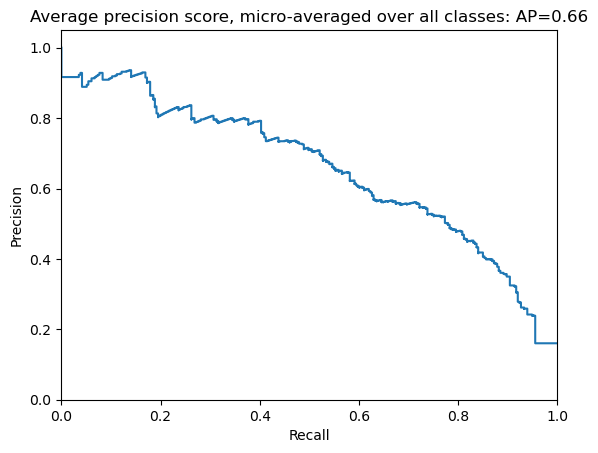

In [41]:
y_bin = label_binarize(y, classes=subdomains)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=54)

ovr_clf = OneVsRestClassifier(best_clf)
ovr_clf.fit(X_train, y_train)

y_score = ovr_clf.predict_proba(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(subdomains)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))

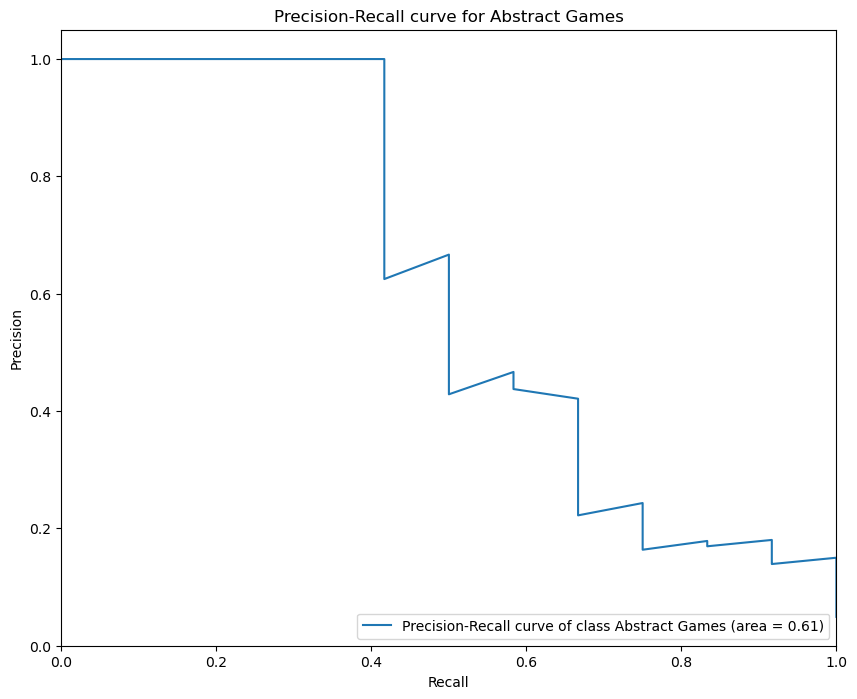

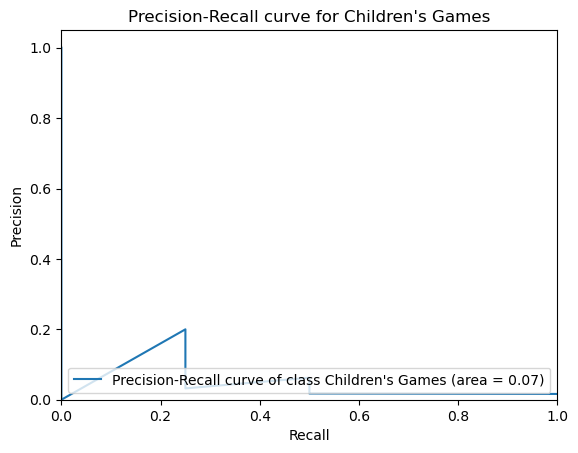

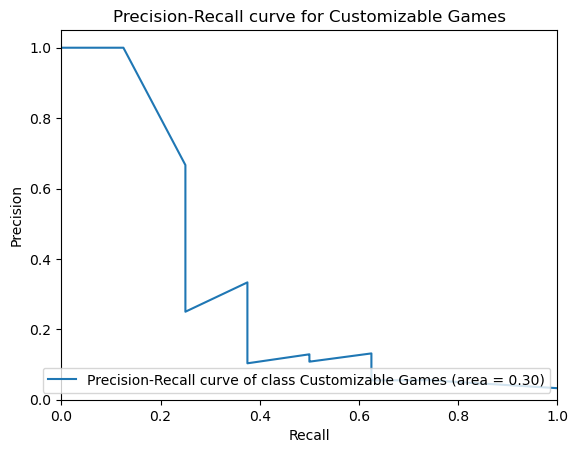

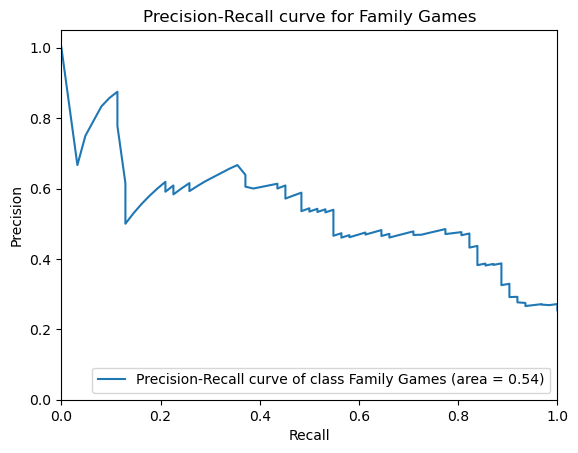

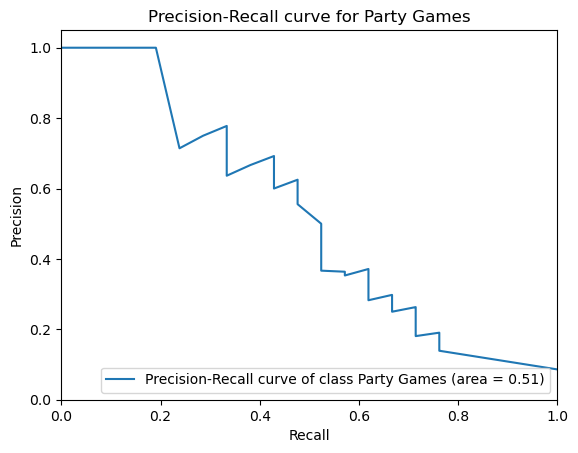

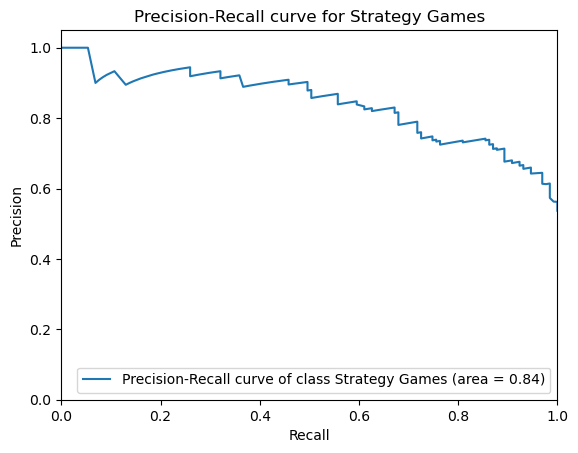

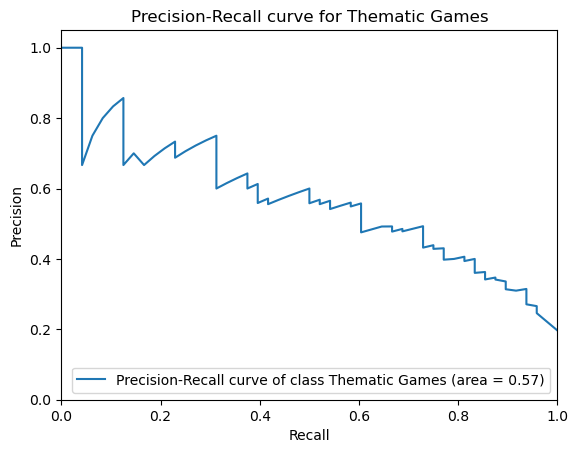

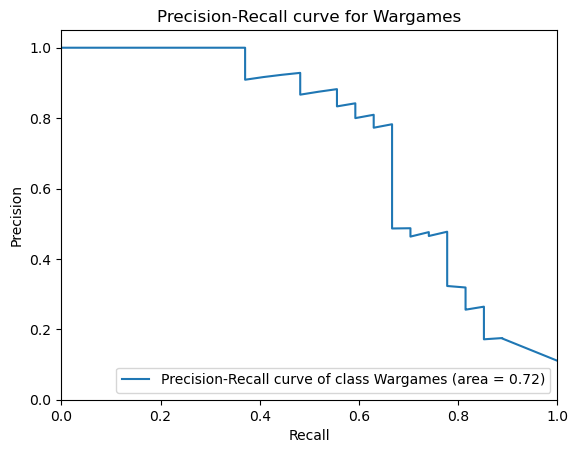

In [47]:
# For each class
plt.figure(figsize=(10, 8))
for i in range(len(subdomains)):
    # Initialize figure for this class

    plt.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (area = {1:0.2f})'
                                           ''.format(subdomains[i], average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for {subdomains[i]}')
    plt.legend(loc="lower right")
    plt.show()